# 网络模型

In [1]:
""" Parts of the U-Net model """
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super(DoubleConv,self).__init__()#初始化权重
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super(Down,self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up,self).__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
""" Full assembly of the parts to form the complete network """



class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels,64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x
class PatchGan(nn.Module):  
    def __init__(self, n_channels):
        super(PatchGan, self).__init__()
        
        self.inc = DoubleConv(n_channels+1, 64)
        self.pool = nn.MaxPool2d(2)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.zero_pad1 = nn.ZeroPad2d(1)
        self.conv1 = nn.Conv2d(256,512,kernel_size=4, stride=2,padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.leaky_relu = nn.LeakyReLU()
        self.zero_pad2 = nn.ZeroPad2d(1)
        self.conv2 = nn.Conv2d(512,1,kernel_size=4, stride=1,padding=0, bias=False)
        
    def forward(self, x,y):
        x0 = torch.cat([x, y], dim=1)
        x1 = self.inc(x0)
        #x1 = self.pool(x1)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.zero_pad1(x3)
        x5 = self.conv1(x4)
        x6 = self.batchnorm1(x5)
        x7 = self.leaky_relu(x6)
        x8 = self.zero_pad2(x7)
        out = self.conv2(x8)
        return out
# custom weights initialization called on netG and netD，自定义权重
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0,1)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 1)
        nn.init.constant_(m.bias.data, 0)    

In [2]:
from torchsummary import summary
# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
discriminator = PatchGan(n_channels=1)
if torch.cuda.is_available():
    discriminator.cuda()
summary(discriminator,[(1,256,256),(1,256,256)],batch_size=-1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,152
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [3]:
from torchsummary import summary
# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
net = UNet(n_channels=1, n_classes=1, bilinear=True)
if torch.cuda.is_available():
    net.cuda()
summary(net,(1,256,256))
#print(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             576
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

# 自定义Dataset

In [2]:
import os
import numpy as np
from torch.utils.data import Dataset,DataLoader
import glob
class CustomFileDataset(Dataset):
    def __init__(self, base_dir, transform=None, target_transform=None,training = True,split = 0.9):
        self.fileList = []
        self.base_dir = base_dir   
        self.orig_dir = os.path.join(self.base_dir, "dataset/orig") 
        self.target_dir = os.path.join(self.base_dir, "dataset/target") 
        for i in glob.glob(self.orig_dir+'/*.npy'):
            self.fileList.append(i.split('\\')[2])
        np.random.shuffle(self.fileList)   
        self.train_set = self.fileList[0:int(len(self.fileList)*split)]#分割数据集
        self.test_set = self.fileList[int(len(self.fileList)*split):-1]
        self.Istraining = training
        #self.transform = transform
        #self.target_transform = target_transform

    def __len__(self):
        if self.Istraining:
            return len(self.train_set)
        else:
            return len(self.test_set)

    def __getitem__(self, idx):
        if self.Istraining:
            orig_path = os.path.join(self.orig_dir, self.train_set[idx])
            target_path = os.path.join(self.target_dir, self.train_set[idx])
            orig = np.load(orig_path)
            orig = np.pad(orig,((0,6),(0,6)))
            target = np.load(target_path)
            target = np.pad(target,((0,6),(0,6)))
        else:
            orig_path = os.path.join(self.orig_dir, self.test_set[idx])
            target_path = os.path.join(self.target_dir, self.test_set[idx])
            orig = np.load(orig_path)
            orig = np.pad(orig,((0,6),(0,6)))
            target = np.load(target_path)  
            target = np.pad(target,((0,6),(0,6)))
        return   np.expand_dims(orig, axis=0), np.expand_dims(target, axis=0)

In [5]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
training_data = CustomFileDataset('D:/PythonProj/ganTest')
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    orig, target = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    #plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(orig.squeeze(), cmap="gray")
plt.show()

NameError: name 'training_data' is not defined

<Figure size 576x576 with 0 Axes>

In [6]:
from torch import optim
#定义生成器损失
def generator_loss(disc_generated_output, gen_output, target,
                   loss_object = nn.BCEWithLogitsLoss(),
                   LAMBDA=100):
    gan_loss = loss_object(disc_generated_output,torch.ones_like( disc_generated_output))
    # Mean absolute error
    l1_loss = torch.mean(torch.abs(target.view(-1) - gen_output.view(-1)))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss
#定义鉴别器损失
def discriminator_loss(disc_real_output, disc_generated_output,
                       loss_object = nn.BCELoss()):    
    real_loss = loss_object(torch.ones_like(disc_real_output).view(-1), disc_real_output.view(-1))
    generated_loss = loss_object(torch.zeros_like(disc_generated_output).view(-1), disc_generated_output.view(-1))
    total_disc_loss = real_loss + generated_loss
    return real_loss,generated_loss
def train_net(Generate,Discriminator,device,
              epochs: int = 1,
              batch_size: int = 4,
              learning_rate: float = 1e-5,beta1 = 0.9
             ):
                          
    # 1初始化模型参数

    if torch.cuda.is_available():
        #Generate.to(device)
        #Discriminator.to(device)
        pass
    optimizerD = optim.Adam(Discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
    optimizerG = optim.Adam(Generate.parameters(), lr=learning_rate, betas=(beta1, 0.999))
    loss_object = nn.BCEWithLogitsLoss()
    # 2. 初始化数据集
    training_data = CustomFileDataset('D:/PythonProj/ganTest')
    testing_data = CustomFileDataset('D:/PythonProj/ganTest',training = False)

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size,  pin_memory=True)
    train_loader = DataLoader(training_data, shuffle=False, **loader_args)
    val_loader = DataLoader(testing_data, shuffle=False,  **loader_args)

    # 4. Begin training
    for epoch in range(epochs):
        Generate.train()
        epoch_loss = 0
        for batch, (orig,target) in enumerate(train_loader, 0):
            assert orig.shape[1] == Generate.n_channels, \
                f'Network has been defined with {Generate.n_channels} input channels, ' \
                f'but loaded images have {orig.shape[1]} channels. Please check that ' \
                'the images are loaded correctly.'
            
            Discriminator.zero_grad()

            orig = orig.to(device=device, dtype=torch.float32)
            target = target.to(device=device, dtype=torch.float32)
            
            disc_real_output = Discriminator(orig, target) 
            
            real_loss = loss_object(disc_real_output,torch.ones_like(disc_real_output))
            real_loss.backward() 

            gen_output = Generate(orig)           
            disc_generated_output = Discriminator(orig, gen_output) 
            
            generated_loss = loss_object(disc_generated_output,torch.zeros_like(disc_generated_output))
            generated_loss.backward()  
            loss_d = (real_loss+generated_loss).item()
            optimizerD.step()   
            
            Generate.zero_grad()  
            gen_output2 = Generate(orig)            
            disc_generated_output2 = Discriminator(orig, gen_output2) 

            gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output2, gen_output2, target)              
            loss_g_t,loss_g_gan = gen_total_loss.item(),gen_gan_loss.item()
            gen_total_loss.backward()              
            optimizerG.step()
            
            if batch % 100 == 0:
                current =  batch * len(orig)
                print(f"epoch:{epoch}/{epochs},disc_loss:{loss_d:>7f}, gen_total_loss:{loss_g_t:>7f},  gen_gan_loss: {loss_g_gan:>7f},{current:>5d}")
            


In [7]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Generate = UNet(n_channels=1, n_classes=1, bilinear=True)
Discriminator = PatchGan(n_channels=1)
#Generate = Generate.apply(weights_init)
#Discriminator = Discriminator.apply(weights_init)  
Generate.cuda()
Discriminator.cuda()
print("initial")

initial


In [8]:
train_net(Generate,Discriminator,device)
torch.save(Generate.state_dict(), 'Generate_weights.pth')
torch.save(Discriminator.state_dict(), 'Discriminator_weights.pth')

epoch:0/1,disc_loss:1.416317, gen_total_loss:28.355738,  gen_gan_loss: 0.704875,    0
epoch:0/1,disc_loss:1.224408, gen_total_loss:12.763578,  gen_gan_loss: 0.868844,  400
epoch:0/1,disc_loss:0.421727, gen_total_loss:11.578916,  gen_gan_loss: 2.012009,  800
epoch:0/1,disc_loss:0.481944, gen_total_loss:8.455978,  gen_gan_loss: 1.820551, 1200
epoch:0/1,disc_loss:0.553162, gen_total_loss:5.674371,  gen_gan_loss: 1.309774, 1600
epoch:0/1,disc_loss:0.431965, gen_total_loss:7.975976,  gen_gan_loss: 1.920678, 2000
epoch:0/1,disc_loss:0.554812, gen_total_loss:7.489043,  gen_gan_loss: 1.766675, 2400
epoch:0/1,disc_loss:1.056648, gen_total_loss:4.634245,  gen_gan_loss: 0.585027, 2800
epoch:0/1,disc_loss:0.788533, gen_total_loss:5.570478,  gen_gan_loss: 1.173825, 3200


In [14]:
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise = torch.randn((1,1,256,256),device=device)
out = Discriminator(noise,noise).detach()
plt.imshow(out.cpu().numpy()[0][0])
#for i,param in enumerate(Generate.parameters(),0):
#    print(i,param)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [15]:
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise = torch.randn((1,1,256,256),device=device)
out = Generate(noise).detach()
plt.imshow(out.cpu().numpy()[0][0])

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

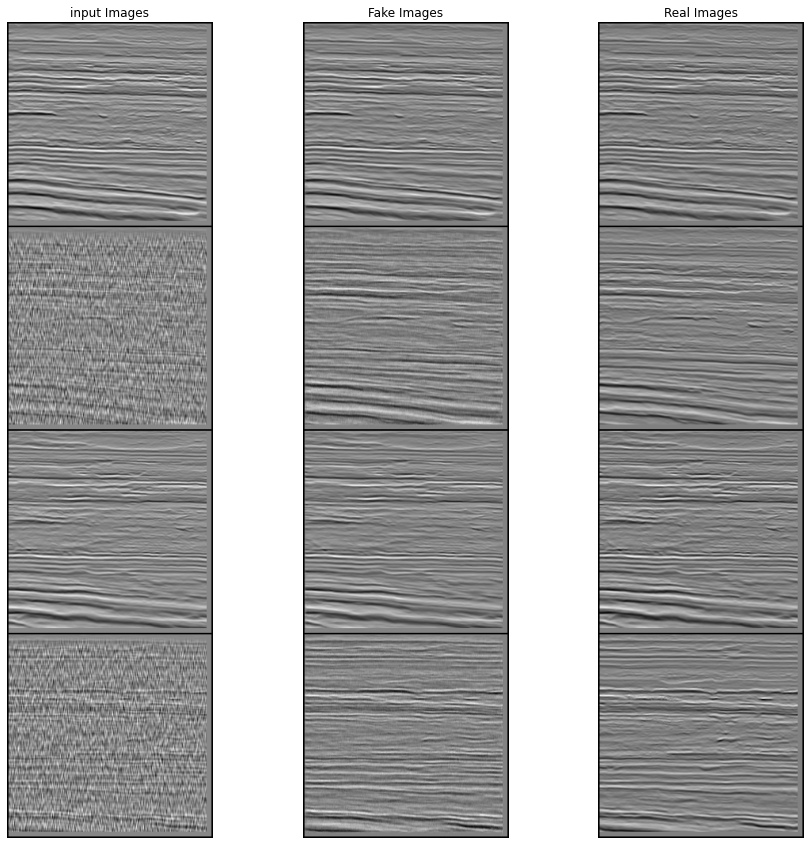

In [37]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt
Generate = UNet(n_channels=1, n_classes=1, bilinear=True) # we do not specify pretrained=True, i.e. do not load default weights
Generate.load_state_dict(torch.load('Generate_weights.pth'))
device = 'cpu'
batch_size = 4
testing_data = CustomFileDataset('D:/PythonProj/ganTest',training = False)
loader_args = dict(batch_size=batch_size,  pin_memory=True)
val_loader = DataLoader(testing_data, shuffle=False,  **loader_args)
input0,target = next(iter(val_loader))
input0 = input0.to(device=device, dtype=torch.float32)
target = target.to(device=device, dtype=torch.float32)
Generate.to('cpu')
out = Generate(input0)
def GetImageList(tensor):
    out = []
    for i in range(tensor.size()[0]):
        out.append(tensor[i])
    return out
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis("off")
plt.title("input Images")
plt.imshow(np.transpose(vutils.make_grid(GetImageList(input0.to(device)), padding=2, normalize=True),(2,1,0)))

# Plot the fake images from the last epoch
plt.subplot(1,3,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(GetImageList(out.detach().cpu()), padding=2, normalize=True),(2,1,0)))
#plt.show()

plt.subplot(1,3,3)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(GetImageList(target.to(device)), padding=2, normalize=True),(2,1,0)))
plt.show()

In [28]:
vutils.make_grid(GetImageList(target.to(device)), padding=5, normalize=True).size()

torch.Size([3, 266, 1049])